
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy/v0.12?urlpath=lab/tree/spectrum_analysis.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/tutorials).
- **Source files:**
[spectrum_analysis.ipynb](../_static/notebooks/spectrum_analysis.ipynb) |
[spectrum_analysis.py](../_static/notebooks/spectrum_analysis.py)
</div>


# Spectral analysis with Gammapy

## Introduction

This notebook explains in detail how to use the classes in [gammapy.spectrum](../spectrum/index.rst) and related ones.

Based on a datasets of 4 Crab observations with H.E.S.S. (simulated events for now) we will perform a full region based spectral analysis, i.e. extracting source and background counts from certain 
regions, and fitting them using the forward-folding approach. We will use the following classes

Data handling:

* [gammapy.data.DataStore](../api/gammapy.data.DataStore.rst)
* [gammapy.data.DataStoreObservation](../api/gammapy.data.DataStoreObservation.rst)
* [gammapy.data.ObservationStats](../api/gammapy.data.ObservationStats.rst)
* [gammapy.data.ObservationSummary](../api/gammapy.data.ObservationSummary.rst)

To extract the 1-dim spectral information:

* [gammapy.spectrum.SpectrumExtraction](../api/gammapy.spectrum.SpectrumExtraction.rst)
* [gammapy.background.ReflectedRegionsBackgroundEstimator](../api/gammapy.background.ReflectedRegionsBackgroundEstimator.rst)

To perform the joint fit:

* [gammapy.spectrum.SpectrumDatasetOnOff](../api/gammapy.spectrum.SpectrumDatasetOnOff.rst)
* [gammapy.spectrum.SpectrumDatasetOnOffStacker](../api/gammapy.spectrum.SpectrumDatasetOnOffStacker.rst)
* [gammapy.spectrum.models.PowerLaw](../api/gammapy.spectrum.models.PowerLaw.rst)
* [gammapy.spectrum.models.ExponentialCutoffPowerLaw](../api/gammapy.spectrum.models.ExponentialCutoffPowerLaw.rst)
* [gammapy.spectrum.models.LogParabola](../api/gammapy.spectrum.models.LogParabola.rst)

To compute flux points (a.k.a. "SED" = "spectral energy distribution")

* [gammapy.spectrum.FluxPoints](../api/gammapy.spectrum.FluxPoints.rst)
* [gammapy.spectrum.FluxPointsEstimator](../api/gammapy.spectrum.FluxPointsEstimator.rst)

Feedback welcome!

## Setup

As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Check package versions
import gammapy
import numpy as np
import astropy
import regions

print("gammapy:", gammapy.__version__)
print("numpy:", np.__version__)
print("astropy", astropy.__version__)
print("regions", regions.__version__)

gammapy: 0.12
numpy: 1.16.2
astropy 3.1.1
regions 0.3


In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.maps import Map
from gammapy.utils.fitting import Fit
from gammapy.data import ObservationStats, ObservationSummary, DataStore
from gammapy.background import ReflectedRegionsBackgroundEstimator
from gammapy.spectrum.models import PowerLaw
from gammapy.spectrum import (
    SpectrumExtraction,
    SpectrumDatasetOnOff,
    SpectrumDatasetOnOffStacker,
    CrabSpectrum,
    FluxPointsEstimator,
    FluxPointsDataset,
)

## Load Data

First, we select and load some H.E.S.S. observations of the Crab nebula (simulated events for now).

We will access the events, effective area, energy dispersion, livetime and PSF for containement correction.

In [4]:
datastore = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")
obs_ids = [23523, 23526, 23559, 23592]
observations = datastore.get_observations(obs_ids)

## Define Target Region

The next step is to define a signal extraction region, also known as on region. In the simplest case this is just a [CircleSkyRegion](http://astropy-regions.readthedocs.io/en/latest/api/regions.CircleSkyRegion.html#regions.CircleSkyRegion), but here we will use the ``Target`` class in gammapy that is useful for book-keeping if you run several analysis in a script.

In [5]:
target_position = SkyCoord(ra=83.63, dec=22.01, unit="deg", frame="icrs")
on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

## Create exclusion mask

We will use the reflected regions method to place off regions to estimate the background level in the on region.
To make sure the off regions don't contain gamma-ray emission, we create an exclusion mask.

Using http://gamma-sky.net/ we find that there's only one known gamma-ray source near the Crab nebula: the AGN called [RGB J0521+212](http://gamma-sky.net/#/cat/tev/23) at GLON = 183.604 deg and GLAT = -8.708 deg.

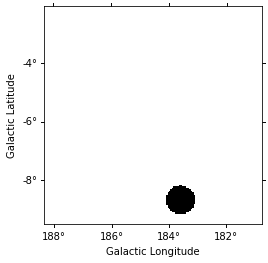

In [6]:
exclusion_region = CircleSkyRegion(
    center=SkyCoord(183.604, -8.708, unit="deg", frame="galactic"),
    radius=0.5 * u.deg,
)

skydir = target_position.galactic
exclusion_mask = Map.create(
    npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", coordsys="GAL"
)

mask = exclusion_mask.geom.region_mask([exclusion_region], inside=False)
exclusion_mask.data = mask
exclusion_mask.plot();

## Estimate background

Next we will manually perform a background estimate by placing [reflected regions](../background/reflected.rst) around the pointing position and looking at the source statistics. This will result in a  [gammapy.background.BackgroundEstimate](../api/gammapy.background.BackgroundEstimate.rst) that serves as input for other classes in gammapy.

In [7]:
background_estimator = ReflectedRegionsBackgroundEstimator(
    observations=observations,
    on_region=on_region,
    exclusion_mask=exclusion_mask,
)

background_estimator.run()

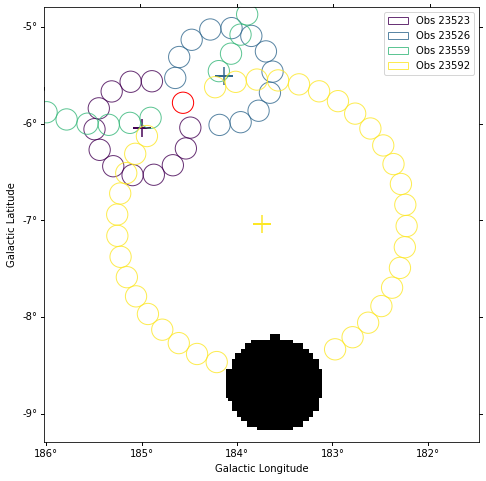

In [8]:
plt.figure(figsize=(8, 8))
background_estimator.plot(add_legend=True);

## Source statistic

Next we're going to look at the overall source statistics in our signal region. For more info about what debug plots you can create check out the [ObservationSummary](../api/gammapy.data.ObservationSummary.rst#gammapy.data.ObservationSummary) class.

*** Observation summary report ***
Observation Id: 23526
Livetime: 0.437 h
On events: 201
Off events: 225
Alpha: 0.083
Bkg events in On region: 18.75
Excess: 182.25
Excess / Background: 9.72
Gamma rate: 6.95 1 / min
Bkg rate: 0.72 1 / min
Sigma: 21.86



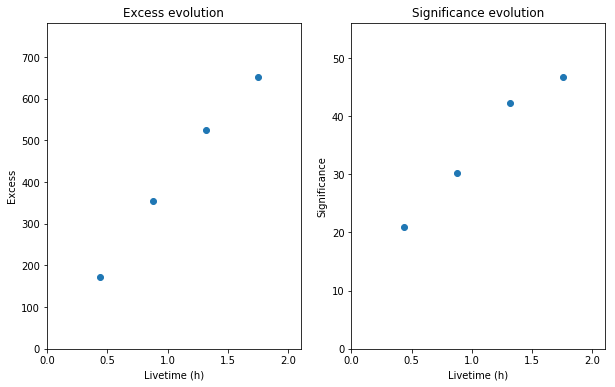

In [9]:
stats = []
for obs, bkg in zip(observations, background_estimator.result):
    stats.append(ObservationStats.from_observation(obs, bkg))

print(stats[1])

obs_summary = ObservationSummary(stats)
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(121)

obs_summary.plot_excess_vs_livetime(ax=ax1)
ax2 = fig.add_subplot(122)
obs_summary.plot_significance_vs_livetime(ax=ax2);

## Extract spectrum

Now, we're going to extract a spectrum using the [SpectrumExtraction](../api/gammapy.spectrum.SpectrumExtraction.rst) class. We provide the reconstructed energy binning we want to use. It is expected to be a Quantity with unit energy, i.e. an array with an energy unit. We also provide the true energy binning to use.

In [10]:
e_reco = np.logspace(-1, np.log10(40), 40) * u.TeV
e_true = np.logspace(np.log10(0.05), 2, 200) * u.TeV

Instantiate a [SpectrumExtraction](../api/gammapy.spectrum.SpectrumExtraction.rst) object that will do the extraction. The containment_correction parameter is there to allow for PSF leakage correction if one is working with full enclosure IRFs. We also compute a threshold energy and store the result in OGIP compliant files (pha, rmf, arf). This last step might be omitted though.

In [11]:
extraction = SpectrumExtraction(
    observations=observations,
    bkg_estimate=background_estimator.result,
    containment_correction=False,
    e_reco=e_reco,
    e_true=e_true,
)

In [12]:
%%time
extraction.run()

CPU times: user 1.8 s, sys: 32.3 ms, total: 1.83 s
Wall time: 1.85 s


Now we can (optionally) compute the energy thresholds for the analysis, acoording to different methods. Here we choose the energy where the effective area drops below 10% of the maximum:

In [13]:
# Add a condition on correct energy range in case it is not set by default
extraction.compute_energy_threshold(method_lo="area_max", area_percent_lo=10.0)

Let's take a look at the datasets, we just extracted:

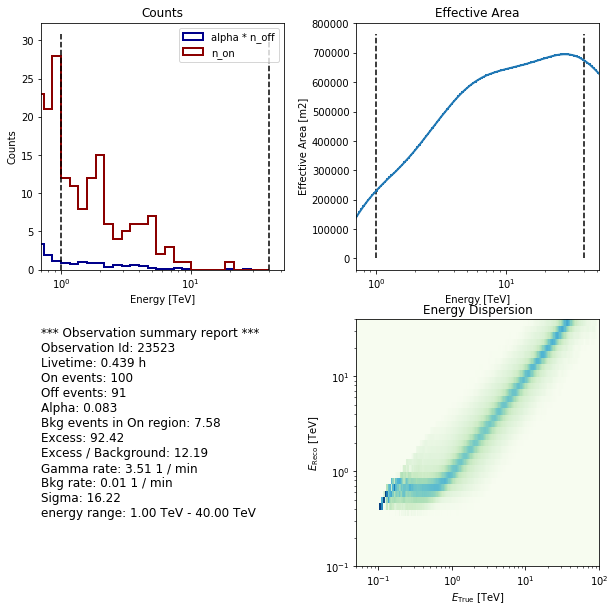

In [14]:
# Requires IPython widgets
# extraction.spectrum_observations.peek()

extraction.spectrum_observations[0].peek()

Finally you can write the extrated datasets to disk using the OGIP format (PHA, ARF, RMF, BKG, see [here](https://gamma-astro-data-formats.readthedocs.io/en/latest/spectra/ogip/index.html) for details):

In [15]:
# ANALYSIS_DIR = "crab_analysis"
# extraction.write(outdir=ANALYSIS_DIR, overwrite=True)

If you want to read back the datasets from disk you can use:

In [16]:
# datasets = []
# for obs_id in obs_ids:
#     filename = ANALYSIS_DIR + "/ogip_data/pha_obs{}.fits".format(obs_id)
#     datasets.append(SpectrumDatasetOnOff.from_ogip_files(filename))

## Fit spectrum

Now we'll fit a global model to the spectrum. First we do a joint likelihood fit to all observations. If you want to stack the observations see below. We will also produce a debug plot in order to show how the global fit matches one of the individual observations.

In [17]:
model = PowerLaw(
    index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)

datasets_joint = extraction.spectrum_observations

for dataset in datasets_joint:
    dataset.model = model

fit_joint = Fit(datasets_joint)
result_joint = fit_joint.run()

# we make a copy here to compare it later
model_best_joint = model.copy()
model_best_joint.parameters.covariance = result_joint.parameters.covariance

In [18]:
print(result_joint)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 47
	total stat : 113.58



(0, 25)

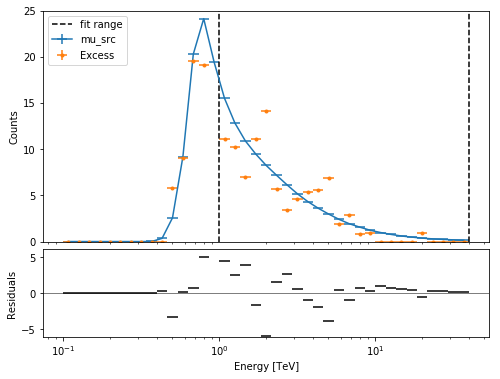

In [19]:
plt.figure(figsize=(8, 6))
ax_spectrum, ax_residual = datasets_joint[0].plot_fit()
ax_spectrum.set_ylim(0, 25)

## Compute Flux Points

To round up our analysis we can compute flux points by fitting the norm of the global model in energy bands. We'll use a fixed energy binning for now:

In [20]:
e_min, e_max = 0.7, 30
e_edges = np.logspace(np.log10(e_min), np.log10(e_max), 11) * u.TeV

Now we create an instance of the `FluxPointsEstimator`, by passing the dataset and the energy binning:

In [21]:
fpe = FluxPointsEstimator(datasets=datasets_joint, e_edges=e_edges)
flux_points = fpe.run()

Here is a the table of the resulting flux points:

In [22]:
flux_points.table_formatted

<Table length=10>
 e_ref   e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
  TeV     TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
float64 float64 float64 ...     float64         float64         float64    
------- ------- ------- ... --------------- --------------- ---------------
  0.859   0.737   1.002 ...       4.959e-12       5.165e-12       4.758e-12
  1.261   1.002   1.588 ...       1.347e-12       1.394e-12       1.302e-12
  1.852   1.588   2.160 ...       8.169e-13       8.499e-13       7.847e-13
  2.518   2.160   2.936 ...       4.341e-13       4.547e-13       4.141e-13
  3.697   2.936   4.656 ...       1.433e-13       1.512e-13       1.357e-13
  5.429   4.656   6.330 ...       8.859e-14       9.533e-14       8.213e-14
  7.971   6.330  10.037 ...       3.363e-14       3.663e-14       3.081e-14
 11.703  10.037  13.647 ...       1.940e-14       2.211e-14       1.689e-14
 17.183  13.647  21.636 ...       4.683e-15       5.951e-15       5.159e-15
 25.229  21.636  29.419 ...       8.345e-18       1.705e-15       1.021e-20

Now we plot the flux points and their likelihood profiles. For the plotting of upper limits we choose a threshold of TS < 4.

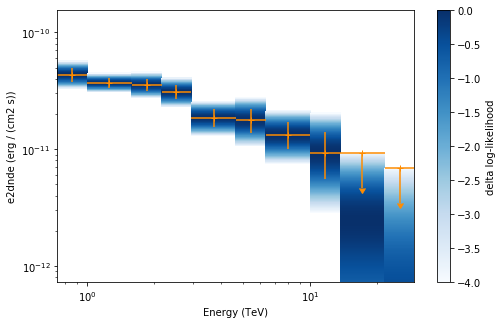

In [23]:
plt.figure(figsize=(8, 5))
flux_points.table["is_ul"] = flux_points.table["ts"] < 4
ax = flux_points.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
flux_points.to_sed_type("e2dnde").plot_likelihood(ax=ax)

The final plot with the best fit model, flux points and residuals can be quickly made like this: 

In [24]:
flux_points_dataset = FluxPointsDataset(
    data=flux_points, model=model_best_joint
)

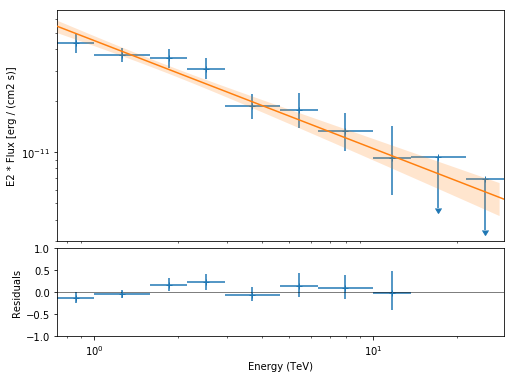

In [25]:
plt.figure(figsize=(8, 6))
flux_points_dataset.peek();

## Stack observations

And alternative approach to fitting the spectrum is stacking all observations first and the fitting a model. For this we first stack the individual datasets using the `SpectrumDatasetOnOffStacker` class:

In [26]:
stacker = SpectrumDatasetOnOffStacker(datasets_joint)
dataset_stacked = stacker.run()

Again we set the model on the dataset we would like to fit (in this case it's only a singel one) and pass it to the `Fit` object:

In [27]:
dataset_stacked.model = model
stacked_fit = Fit([dataset_stacked])
result_stacked = stacked_fit.run()

# make a copy to compare later
model_best_stacked = model.copy()
model_best_stacked.parameters.covariance = result_stacked.parameters.covariance

In [28]:
print(result_stacked)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 26
	total stat : 28.85



In [29]:
model_best_joint.parameters.to_table()

<Table length=3>
   name     value     error        unit        min     max   frozen
   str9    float64   float64      str14      float64 float64  bool 
--------- --------- --------- -------------- ------- ------- ------
    index 2.633e+00 7.598e-02                    nan     nan  False
amplitude 2.814e-11 1.891e-12 cm-2 s-1 TeV-1     nan     nan  False
reference 1.000e+00 0.000e+00            TeV     nan     nan   True

In [30]:
model_best_stacked.parameters.to_table()

<Table length=3>
   name     value     error        unit        min     max   frozen
   str9    float64   float64      str14      float64 float64  bool 
--------- --------- --------- -------------- ------- ------- ------
    index 2.634e+00 7.601e-02                    nan     nan  False
amplitude 2.814e-11 1.892e-12 cm-2 s-1 TeV-1     nan     nan  False
reference 1.000e+00 0.000e+00            TeV     nan     nan   True

Finally, we compare the results of our stacked analysis to a previously published Crab Nebula Spectrum for reference. This is available in `gammapy.spectrum`.

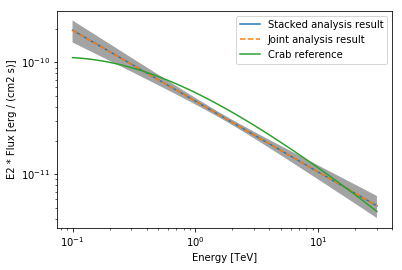

In [31]:
plot_kwargs = {
    "energy_range": [0.1, 30] * u.TeV,
    "energy_power": 2,
    "flux_unit": "erg-1 cm-2 s-1",
}

# plot stacked model
model_best_stacked.plot(**plot_kwargs, label="Stacked analysis result")
model_best_stacked.plot_error(**plot_kwargs)

# plot joint model
model_best_joint.plot(**plot_kwargs, label="Joint analysis result", ls="--")
model_best_joint.plot_error(**plot_kwargs)

CrabSpectrum().model.plot(**plot_kwargs, label="Crab reference")
plt.legend()

## Exercises

Now you have learned the basics of a spectral analysis with Gammapy. To practice you can continue with the following exercises:

- Fit a different spectral model to the data. You could try e.g. an `ExponentialCutoffPowerLaw` or `LogParabola` model.
- Compute flux points for the stacked dataset.
- Create a `FluxPointsDataset` with the flux points you have computed for the stacked dataset and fit the flux points again with obe of the spectral models. How does the result compare to the best fit model, that was directly fitted to the counts data?